# Time Series and Forecasting Models: ARIMA 

## 1. Introduction

A time series is basically a series of data points ordered in time and is an important factor in predicting stock market trends. In time series forecasting models, time is the independent variable and the goal is to predict future values based on previously observed values. 

There are many ways to model a time series in order to make predictions including Moving Averages MA(q), Autoregression AR(p), and combining these to create ARMA(p,q), ARIMA(p,q,d), SARIMA(p,q,d)(P,Q,D,s) models.

Here we will focus on the AutoRegressive Integrated Moving Average (ARIMA) model.

## 2. Install/import libraries

In [1]:
%pip install mplfinance pmdarima

   ---------------------------------------- 0.0/711.9 kB ? eta -:--:--
   ---------------------------------------- 711.9/711.9 kB 7.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------------------------------- - 2.6/2.8 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.4 MB/s  0:00:00

   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   -------------------- ------------------- 1/2 [pmdarima]
   -------------------- ------------------- 1/2 [pmdarima]
   ---------------------------------------- 2/2 [pmdarima]

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from scipy import stats
from scipy.stats import zscore

from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product
from tqdm.notebook import tqdm

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [20]:
try:
    ftse100_stocks = pd.read_pickle("ftse100_stocks.pkl")
except FileNotFoundError:
    ftse100_stocks = yf.download("AZN.L GSK.L ULVR.L BP.L HSBA.L", 
                                  start=datetime.datetime(2010, 1, 1), 
                                  end=datetime.datetime(2019, 12, 31), group_by='tickers')

ftse100_stocks.head()

[*********************100%***********************]  5 of 5 completed


Ticker            AZN.L                                                  \
Price              Open         High          Low        Close   Volume   
Date                                                                      
2010-01-04  2894.237924  2928.030537  2894.237924  2923.061035  2091679   
2010-01-05  2918.092282  2931.509940  2883.305759  2889.766113  2869739   
2010-01-06  2891.255989  2891.255989  2833.112821  2857.463379  3136541   
2010-01-07  2861.438725  2907.655085  2861.438725  2892.746582  3748200   
2010-01-08  2903.182051  2909.642402  2871.874200  2890.758301  2473846   

Ticker          HSBA.L                                                ...  \
Price             Open        High         Low       Close    Volume  ...   
Date                                                                  ...   
2010-01-04  707.534729  720.628052  707.237166  720.628052  15139314  ...   
2010-01-05  717.156368  741.160784  717.156368  731.043213  27480532  ...   
2010-01-06  731.142334  737.986589  728.265810  734.415710  17203196  ...   
2010-01-07  729.158837  736.399886  724.199247  730.547546  26192632  ...   
2010-01-08  734.217439  736.498837  723.107949  734.019043  20725091  ...   

Ticker           ULVR.L                                                  \
Price              Open         High          Low        Close   Volume   
Date                                                                      
2010-01-04  2112.804796  2133.007664  2106.424905  2122.374512  1649773   
2010-01-05  2115.995637  2123.438968  2064.956724  2076.653076  2154892   
2010-01-06  2066.018783  2078.778564  2057.512262  2078.778564  2519864   
2010-01-07  2071.335762  2085.158984  2047.942823  2053.259521  2951063   
2010-01-08  2063.892626  2071.335712  2038.373057  2058.575928  1771076   

Ticker            BP.L                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2010-01-04  596.922126  608.424255  596.723801  608.424255  17956918  
2010-01-05  609.614224  615.960265  604.557266  614.869507  28352666  
2010-01-06  613.778887  617.745148  609.316843  614.175537  22054752  
2010-01-07  612.093151  620.918105  611.894826  618.042542  30630196  
2010-01-08  616.852522  619.232302  610.704868  616.455933  22458240  

[5 rows x 25 columns]

In [21]:
# Create dataframe of AZN.L stock data

try:
    azn = ftse100_stocks['AZN.L']
except (KeyError, TypeError):
    azn = ftse100_stocks[('AZN.L', slice(None))]
                                     
azn.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,2894.237924,2928.030537,2894.237924,2923.061035,2091679
2010-01-05,2918.092282,2931.509940,2883.305759,2889.766113,2869739
2010-01-06,2891.255989,2891.255989,2833.112821,2857.463379,3136541
2010-01-07,2861.438725,2907.655085,2861.438725,2892.746582,3748200
2010-01-08,2903.182051,2909.642402,2871.874200,2890.758301,2473846


In [22]:
# Create Dataframe for Adjusted Close prices

try:
    azn_adj = azn[['Adj Close']].copy()
except (KeyError, TypeError):
    azn_adj = azn[['Close']].copy()
    azn_adj.columns = ['Adj Close']
azn_adj

,Adj Close
Date,
2010-01-04,2923.061035
2010-01-05,2889.766113
2010-01-06,2857.463379
2010-01-07,2892.746582
2010-01-08,2890.758301
...,...
2019-12-20,7796.951172
2019-12-23,7735.039062
2019-12-24,7703.083008


In [23]:
# Plot Adjusted Close price

def azn_adj_plot(title_txt="", label_txt=""):
  sns.set(rc={'figure.figsize':(16, 8)})
  azn_adj.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

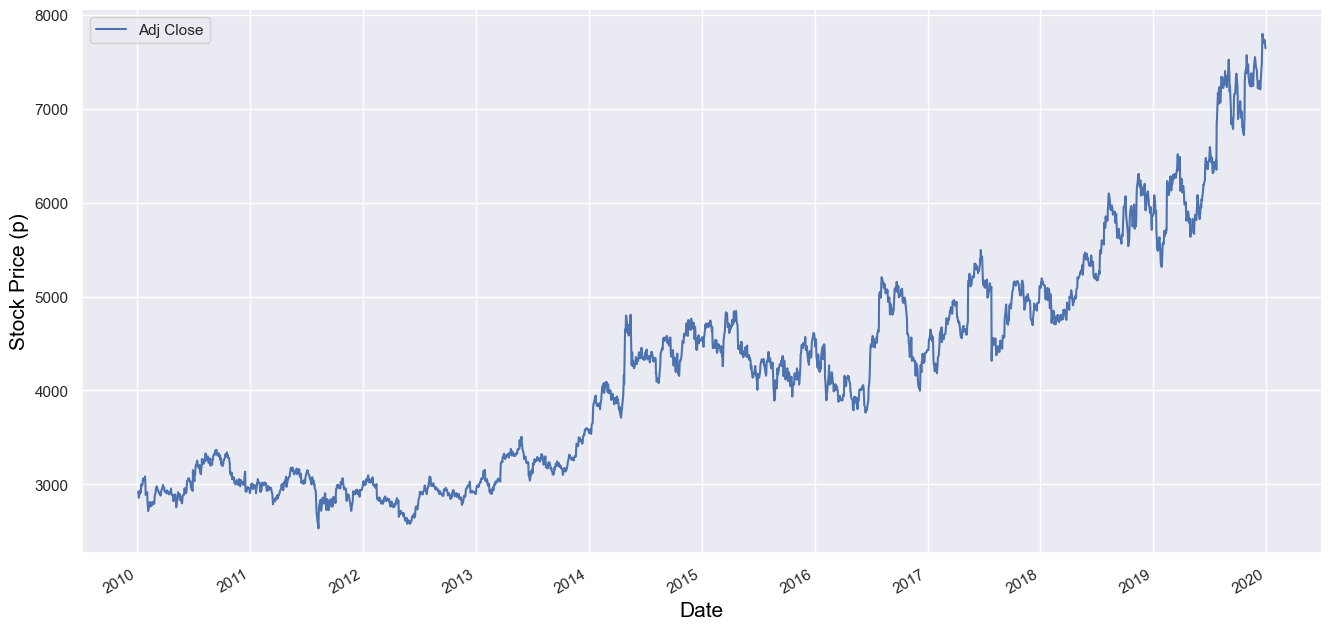

In [24]:
title_txt = "AZN.L Adjusted Close Price from 2010-2019"
label_txt = "AZN.L Adj Close"

azn_adj_plot()

## 4. Seasonality

Seasonality in time series data refers to period fluctuations or cyclical patterns. Differencing can be used to check for seasonality.

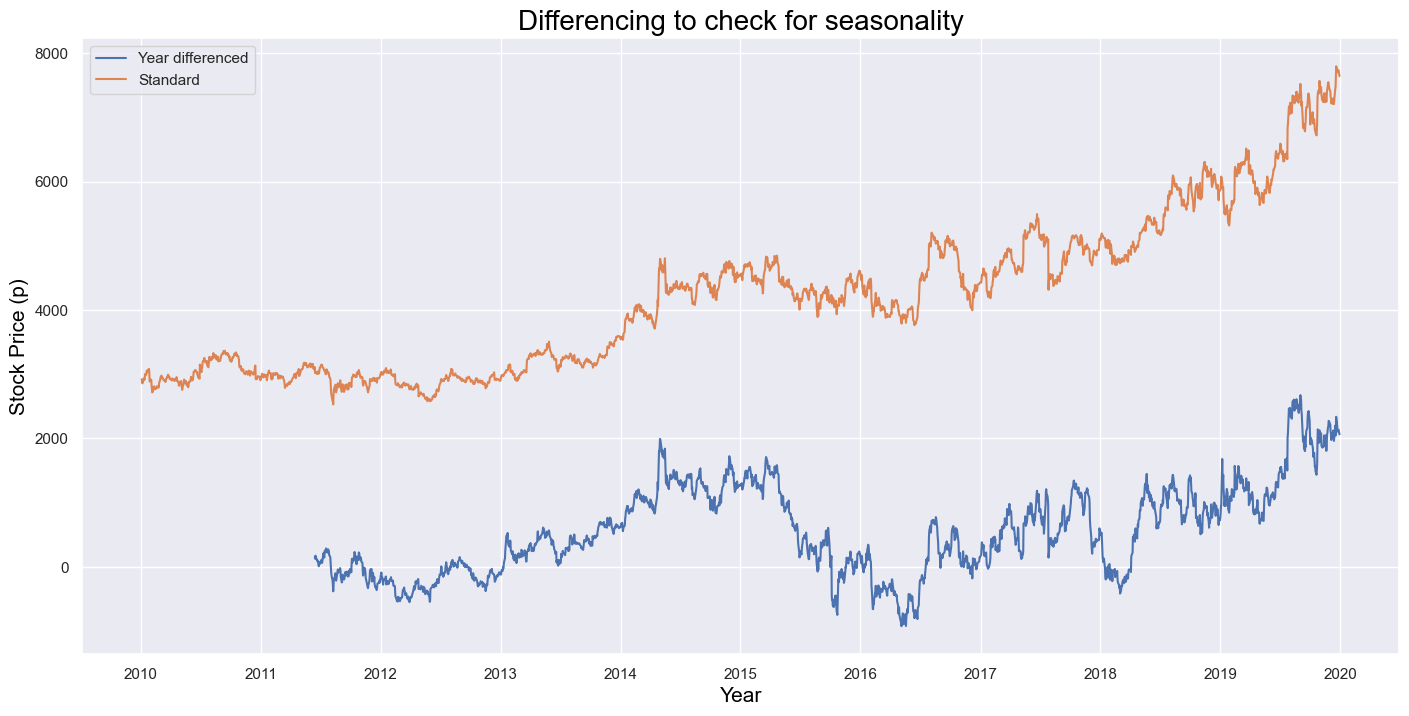

In [27]:
# Plot Adjusted Close price and price after differencing by one year
# removing the first year as it's NaN

year_diff = azn_adj.diff(periods=365)[365:]
plt.figure(figsize=(17, 8))
plt.plot(year_diff .index, year_diff , label='Year differenced')
plt.plot(azn.index, azn['Close'], label='Standard')
plt.title("Differencing to check for seasonality", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
plt.grid(True)
plt.legend();

The difference transform does not appear to show a less volatile time series so a strong seasonal trend is unlikely. Seasonality can also be derived from an autocorrelation plot.

## 5. Stationarity

A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time. Stock prices are often non-stationary and may contain trends or volatility but different transformations can be made to turn the time series into a stationary process so that it can be modelled.



### 5.1 Augmented Dickey-Fuller (ADF) test

Augmented Dickey-Fuller is the statistical test that we run to determine if a time series is stationary or not. It tests the null hypothesis ($H_{0}$) that a unit root is present in an autoregressive model. If it is, then p > 0, and the null hypothesis that the process is not stationary is true.

Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary. The alternate hypothesis ($H_{1}$) that the data is stationary is accepted. 

In [26]:
# ADF Test to check if price series is stationary

result = adfuller(azn_adj.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.06919777507278568
p-value: 0.9524214343239128
Critial Values:
   1%, -3.432946577138947
Critial Values:
   5%, -2.8626871581881708
Critial Values:
   10%, -2.5673806760176046


The p-value is greater than the significance level of 0.05 and the ADF statistic is higher than any of the critical values, therefore the series is non-stationary. The next step is to determine the order of differencing required to make the series stationary.

### 5.2 Autocorrelation Function (ACF)

Autocorrelation is the similarity between observations as a function of the time lag between them. The ACF plot, or correlogram, will tell us the order of differencing required to remove any autocorrelation in the series.

Autocorrelation is the similarity between observations of the same series at previous times as a function of the time lag between them.




In [28]:
# Plot stock price and ACF plot

def ts_acf(y, lags=None, figsize=(12, 4)):
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ts_ax)
    ts_ax.set_title('AZN.L Adjusted Close Price')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
ts_acf(azn_adj, lags=30)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

The above plots show the original price series and the autocorrelation. There is high autocorrelation, and no clear seasonality. 

## 6. Differencing (d)

The purpose of differencing it to make the time series stationary. The parameter **d** is the order of differencing required to achieve this.  In stationary time series d would be 0 but we need to find the order appropriate to our time series. 

It is the order of Integration (the (I)ntegrated In ARIMA).

### 6.1 Difference once

To get rid of the high autocorrelation and to make the process stationary, we will take the first difference and subtract the time series from itself with a lag of one day (previous value from the current value) to get the returns of the Adjusted Close price. 


In [29]:
# Calculate the first differences of the series by comparing with the element in the previous row 
# and drop NaNs

diff1 = azn_adj.diff().dropna()

In [30]:
# Plot first order of differencing and ACF plot

def diff1_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff1_plot(diff1, lags=30)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

We can see that the returns randomly distribute around the mean of 0.

### 6.2 Difference twice

Differencing once might not be enough to make the series stationary which may require multiple orders of differencing. We will difference twice, or take the returns of the returns.

In [33]:
# Calculate the second order of differencing and drop NaNs

diff2 = azn_adj.diff().diff().dropna()

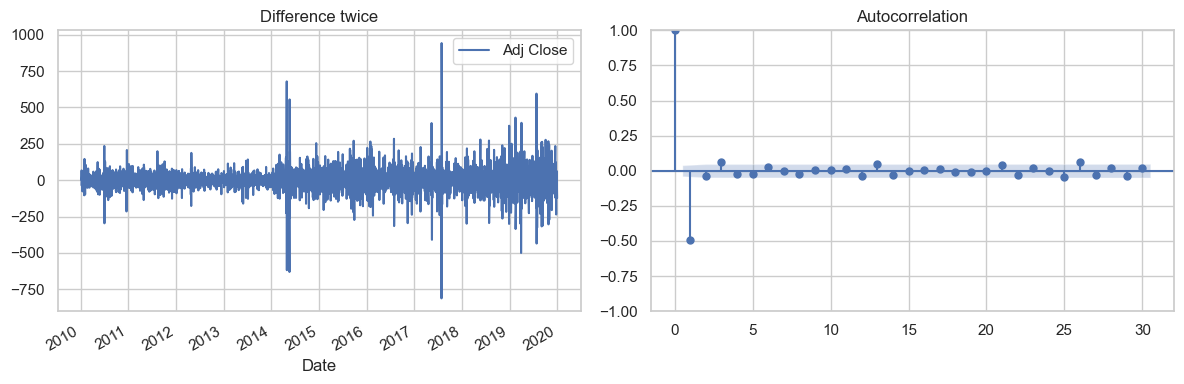

In [34]:
# Plot second order of differencing and ACF plot

def diff2_plot(y, lags=None, figsize=(12, 4)):
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference twice')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff2_plot(diff2, lags=30)

The lag in second order of differencing goes into the far negative which indicates it might have been overdifferenced, so we will choose the order of differencing as 1.

We can also use ndiffs in the **pmdarima** package to get the order of differencing.

In [35]:
ndiffs(azn_adj, test="adf")

1

The differencing required to make the time series stationary is 1.

## 7. Auto Regressive (AR) term (p)

Auto regression is a regression of the time series with itself. We try to find out how correlated the current value is to its previous values with some lag. The parameter **p** represents the maximum lag which is found by looking at the Partial Autocorrelation plot to identify the lag after which most lags are not significant. 

### 7.1 Partial Autocorrelation Function (PACF)

The PACF plot is useful for determining the order of an AR(p) process. It only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond the maximum lag.

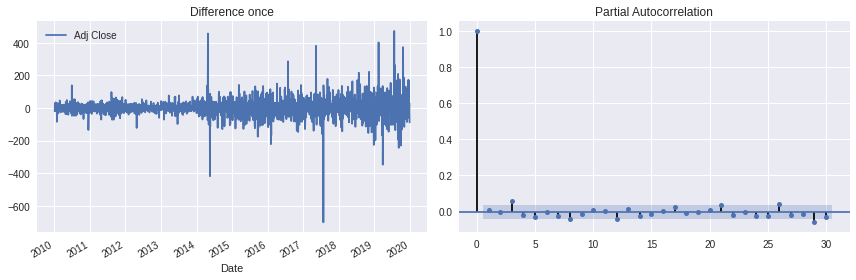

In [ ]:
# Plot first order of differencing and PACF plot

def pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
pacf_plot(diff1, lags=30)

The PACF lag of 3 is above the significance line after which the PACF coefficients are not significant anymore. Therefore,
we will assume an autoregressive process of order 3.


## 8. Moving Average (MA) term (q)


The Moving Average term, represented by the parameter **q**, refers to the number of lagged forecast errors used to predict future values. It is used to reduce noise in a model or smooth it out. The longer the moving average period, the more smoothed out the noise would be. 

An ACF plot is used to identify the correct q value.

### 8.1 Autocorrelation function (ACF)

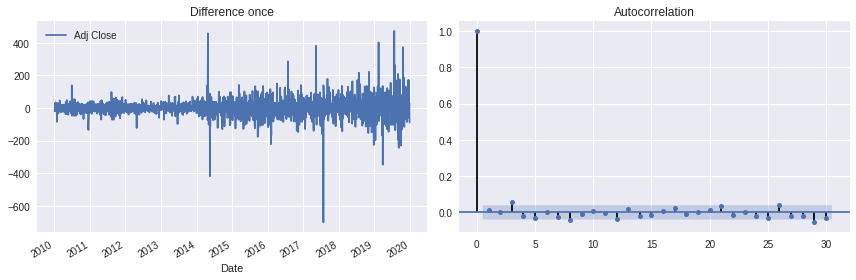

In [ ]:
# Plot ACF to find q term for number of lagged forecast errors

def diff1_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff1_plot(diff1, lags=30)

The ACF plot forecast error 3 is above the significance line and represents the biggest lag after which other lags are not significant.

## 9. Run ADF test on differenced time series

In [ ]:
# ADF test to check if price series is now stationary

result2 = adfuller(diff1)
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')
for key, value in result2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -27.196875138776274
p-value: 0.0
Critial Values:
   1%, -3.4329538144697187
Critial Values:
   5%, -2.8626903542179405
Critial Values:
   10%, -2.567382377622466


The p-value is 0, less than the significance level of 0.05 and the ADF statistic is lower than all of the critical values. The null hypothesis is rejected, and the process is considered to be stationary.

## 10. Modelling

### 10.1 Fitting the ARIMA model

We will now fit the ARIMA model with the (p, d, q) terms of order (3, 1, 3) observed manually from differencing, ACF and PACF plots.

In [ ]:
# Fit ARIMA model with (p, d, q) terms

model = ARIMA(azn_adj, order=(3, 1, 3))
result = model.fit(disp=0)
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2517
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -13579.047
Method:                       css-mle   S.D. of innovations             53.303
Date:                Fri, 26 Mar 2021   AIC                          27174.094
Time:                        14:08:43   BIC                          27220.740
Sample:                             1   HQIC                         27191.023
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.2508      1.108      2.032      0.042       0.080       4.422
ar.L1.D.Adj Close    -0.2318      0.477     -0.486      0.627      -1.166       0.703
ar.L2.D.Adj Close    -0.

We can see from the results summary that there are three AR terms and three MA terms, which are the coefficents for the linear regression, and the p-value for each of them. If any of the coefficients were very close to zero, and the p-value very high, we could remove that term. The p-value needs to be low for the terms to be important for our regression model.

### Plot Residual errors

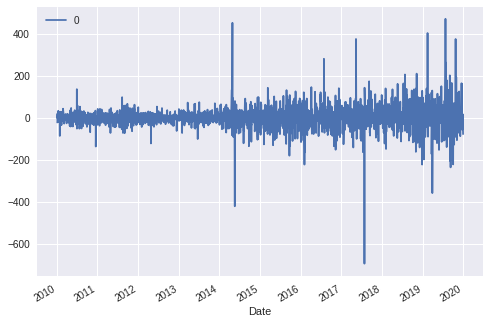

In [ ]:
residuals = pd.DataFrame(result.resid)
residuals.plot();

The residuals are distributed around the mean of 0.

### 10.2 Grid search to select the best order for ARIMA model

In order to optimise our model, for each combination of parameters we fit an ARIMA model with the SARIMAX() function and assess its overall performance. This will result in a dataframe listing the orders and corresponding Akaike’s Information Criterion (AIC) with best models in descending order.

In [ ]:
def optimise_ARIMA(order_list, exog):
    """
    Optimise ARIMA model
    
    :param order_list: list with (p, d, q) tuples
    :param exog: the exogenous variable

    :return: dataframe with parameters and corresponding AIC 
    """
    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=0)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

### 10.3 Parameters to iterate through

In [ ]:
# Parameters to iterate through
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

### 10.4 Search for optimum parameters

In [ ]:
result_df = optimise_ARIMA(order_list, exog=azn_adj['Adj Close'])

In [ ]:
# Print dataframe of results

result_df

,"(p, d, q)",AIC
0,"(4, 1, 4)",27173.411717
1,"(3, 1, 7)",27174.192893
2,"(6, 1, 4)",27174.346060
3,"(3, 1, 2)",27174.401187
4,"(2, 1, 3)",27174.474852
...,...,...
59,"(1, 1, 1)",27182.939042
60,"(1, 1, 2)",27183.129166
61,"(2, 1, 0)",27183.589904
62,"(0, 1, 2)",27183.603971


The order associated with the lowest AIC is (4,1,4). Therefore, this suggests an ARIMA model with an AR(4) process and an MA(4) process.

### 10.5 Fitting the best ARIMA model after Grid Search

In [ ]:
# Fit and print a summary of the best model, which is ARIMA (4,1,4)

best_model = ARIMA(azn_adj, order=(4, 1, 4)).fit(disp=0)
print(best_model.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2517
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -13574.036
Method:                       css-mle   S.D. of innovations             53.195
Date:                Sat, 27 Mar 2021   AIC                          27168.073
Time:                        15:26:04   BIC                          27226.381
Sample:                             1   HQIC                         27189.234
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1962      0.615      3.573      0.000       0.992       3.401
ar.L1.D.Adj Close     1.0226      0.207      4.936      0.000       0.617       1.429
ar.L2.D.Adj Close    -0.

## 11. Study the residuals

Ideally, the residuals will be white noise, with no autocorrelation. One way to test this is by running the **Ljung-Box test** that checks if autocorrelation exists in a time series. The null hypothesis is that the residuals from the ARIMA model have no autocorrelation (or in simple terms - the model is just fine).

We would like to fail to reject the null hypothesis and see the p-value of the test be greater than 0.05 because this means the residuals for our time series model are independent.


In [ ]:
# Ljung-Box test and Augmented Dickey-Fuller test 
ljung_box, p_value = acorr_ljungbox(best_model.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [3.01083476e-03 2.20386929e-01 8.93765290e-01 9.07418197e-01
 1.07399938e+00 1.34730899e+00 3.08216280e+00 3.12123840e+00
 3.12319884e+00 3.13260288e+00]
p-value: [0.95624118 0.89566084 0.82693212 0.92349415 0.95637915 0.96898506
 0.87729885 0.92652022 0.9592094  0.97812886]


Looking at the p-values above, we can see that they are above 0.05. Therefore, we
cannot reject the null hypothesis, and the residuals are indeed not correlated.

### 11.1 Confirm with PACF and ACF plots of residuals

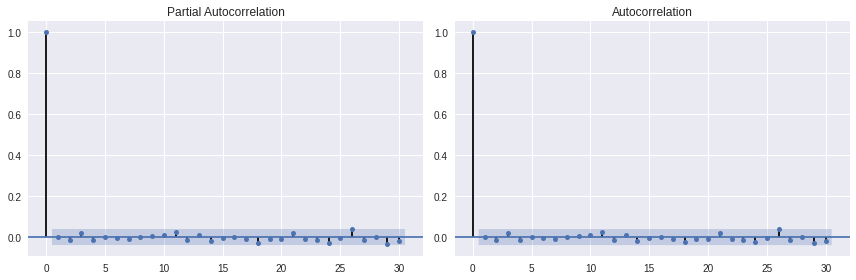

In [ ]:
# Plot PACF and ACF

def pacf_acf_plot(y, lags=None, figsize=(12, 4)):
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    pacf_ax = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
pacf_acf_plot(best_model.resid, lags=30)

The plots above resemble those of white noise, therefore this model is ready to be used for forecasting.

## 12. Predictions

### Plot actual vs predicted result


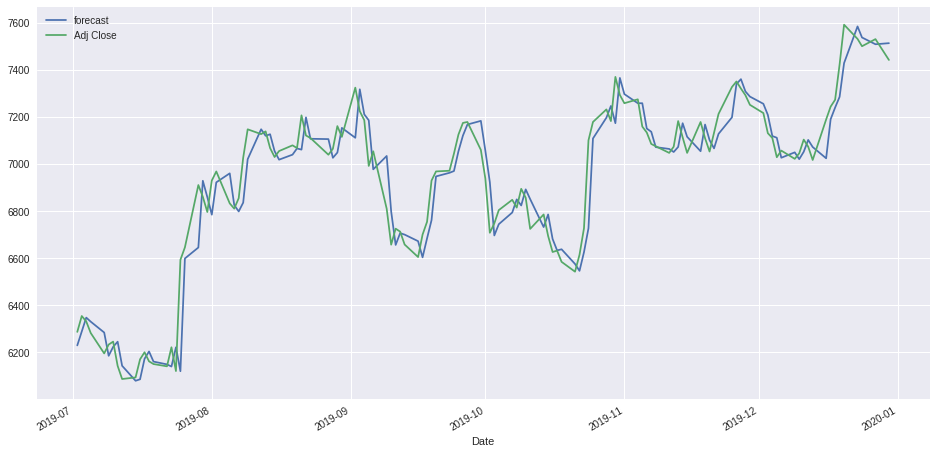

In [ ]:
# Plot Actual vs predicted price for last 6 months of 2019

plt.rc("figure", figsize=(16,8))

best_model.plot_predict(
      start=2391,
      end=2517,
      dynamic=False,
);

Our predictions are very close to our actual values so our ARIMA model is fitted correctly.

### Plot the predicted values

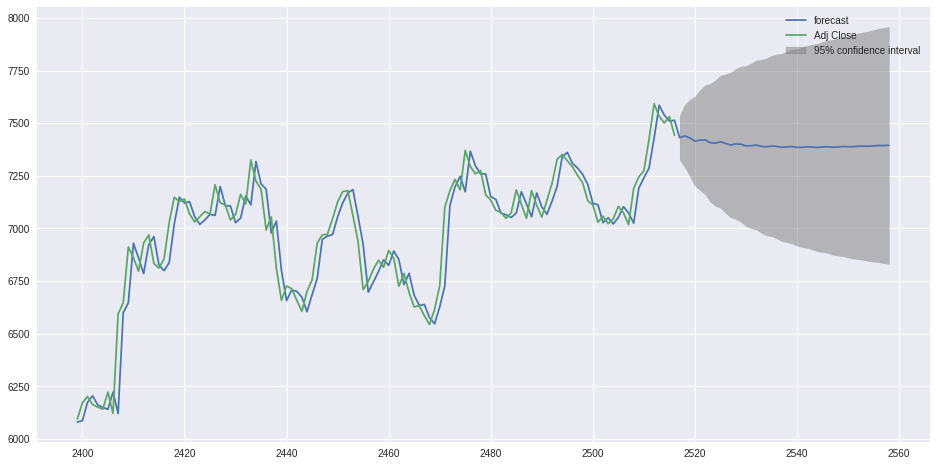

In [ ]:
# Plot Actual vs predicted price extending 2 months into 2020

plt.rc("figure", figsize=(16,8))
best_model.plot_predict(
      start=2400,
      end=2559,
      dynamic=False,
);

We can forecast the next 60 days and visualise the data points for Adjusted Close prices.